<a href="https://colab.research.google.com/github/Mainakdeb/elegant-embryos/blob/main/post_process_lineage_population_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Latest Version of Scikit-Learn

In [ ]:
!pip install --upgrade scikit-learn

## Clone the Devolearn Repository to Access Current Models

In [3]:
!git clone https://github.com/DevoLearn/devolearn.git

Cloning into 'devolearn'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 662 (delta 0), reused 0 (delta 0), pack-reused 661
Receiving objects: 100% (662/662), 322.22 MiB | 35.95 MiB/s, done.
Resolving deltas: 100% (376/376), done.
Checking out files: 100% (40/40), done.


## Copy Datasets from Google Drive

In [ ]:
!cp /content/drive/MyDrive/mydata/epic_subsets/epic_10k.csv /content/
!cp /content/drive/MyDrive/mydata/epic_subsets/scaled_epic_10k.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

In [5]:
import torch
import torchvision.models as models
import torch.nn as nn
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

## Set `device` as Cuda (GPU) for Faster Inference.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Define and Load Model:
* Architecture: ResNet18 with custom linear layers.



In [7]:
model_1 = models.resnet18(pretrained = True)
model_1.fc = model_1.fc = nn.Linear(512, 7)

model_1 = model_1.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


## Loading `model_1` and `scaler_1`
* `model_1` uses weights from the cloned devolearn repository, in order to emulate performance of the devolearn library.
* To ensure even data scaling, I'm also loading up the scaler from devolearn's repository as `scaler_1`

In [9]:
model_1.load_state_dict(torch.load("/content/devolearn/devolearn/lineage_population_model/estimate_lineage_population.pth"))
scaler_1 = joblib.load("/content/devolearn/devolearn/lineage_population_model/scaler/scaler.gz")

## Set Models to `eval()` mode
model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. [source](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch#:~:text=answer%20was%20accepted%E2%80%A6-,model.,will%20do%20it%20for%20you.)

In [ ]:
model_1.eval()

## Define transforms:

In [12]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                      transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Define `researcher_vs_model()`:
Runs inference on frames single video tag using a defined model and scaler, then plots a graph showcasing the predictions and labels.

Args:
* look_for_tag = string containing video id.
* model_ = model for running inference.
* scaler_ = contains data scaling attributes for even scaling and unscaling of attributes.

In [13]:
def researcher_vs_model(look_for_tag, model_, scaler_):
    df_test = pd.read_csv("scaled_epic_10k.csv")
    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
    a_pop_upper_limit = 250
    df_test = df_test[df_test["A"] <= a_pop_upper_limit]
    data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])

    preds = []
    filenames = df_single_cell.filenames.values

    for i in range (len(filenames)):
        image = cv2.imread(filenames[i])
        tensor = mini_transform(image).unsqueeze(0).to(device)
        pred = model_(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])

    plt.rcParams['figure.figsize'] =25, 10

    for i in range(len(real_time_plots)):
        plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )

    for i in range(len(generated_time_plots)):
        plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "--", linewidth = 2 )

    plt.xlabel("time", fontsize = 25)
    plt.ylabel("population", fontsize = 25)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

## Run inference on video (tag 20080709_ceh-27_1_L1) -  using model_1 (Devolearn)

* dotted lines = predicted values
* non dotted lines = labels



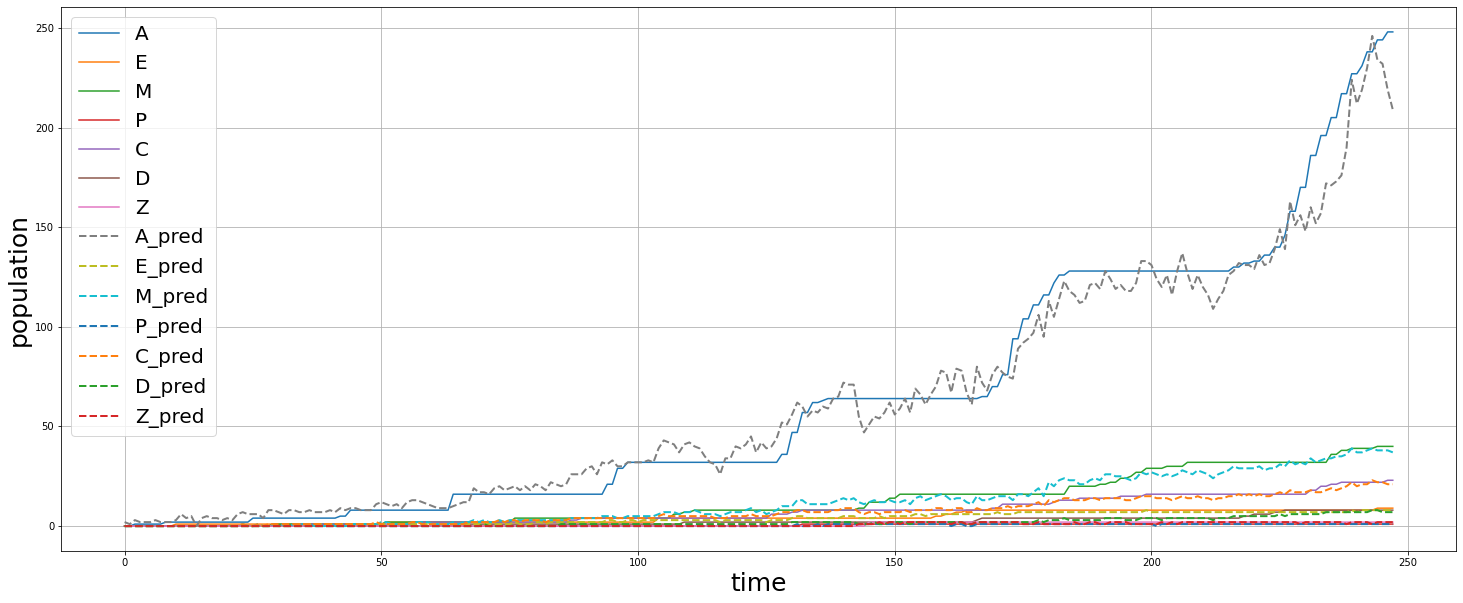

In [14]:
researcher_vs_model(look_for_tag="20080709_ceh-27_1_L1", 
                    model_ = model_1, 
                    scaler_=scaler_1)

In [55]:
def postprocess_preds(preds):
  for i in range(1, len(preds)):
    for j in range(0, len(preds[0])):
      if preds[i][j]<=preds[i-1][j]:
        preds[i][j]=preds[i-1][j]  

  return(preds)

In [56]:
def postprocessed_researcher_vs_model(look_for_tag, model_, scaler_):
    df_test = pd.read_csv("scaled_epic_10k.csv")
    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
    a_pop_upper_limit = 250
    df_test = df_test[df_test["A"] <= a_pop_upper_limit]
    data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])

    preds = []
    filenames = df_single_cell.filenames.values

    for i in range (len(filenames)):
        image = cv2.imread(filenames[i])
        tensor = mini_transform(image).unsqueeze(0).to(device)
        pred = model_(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds=postprocess_preds(preds)
    preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])

    plt.rcParams['figure.figsize'] =25, 10

    for i in range(len(real_time_plots)):
        plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )

    for i in range(len(generated_time_plots)):
        plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "--", linewidth = 2 )

    plt.xlabel("time", fontsize = 25)
    plt.ylabel("population", fontsize = 25)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

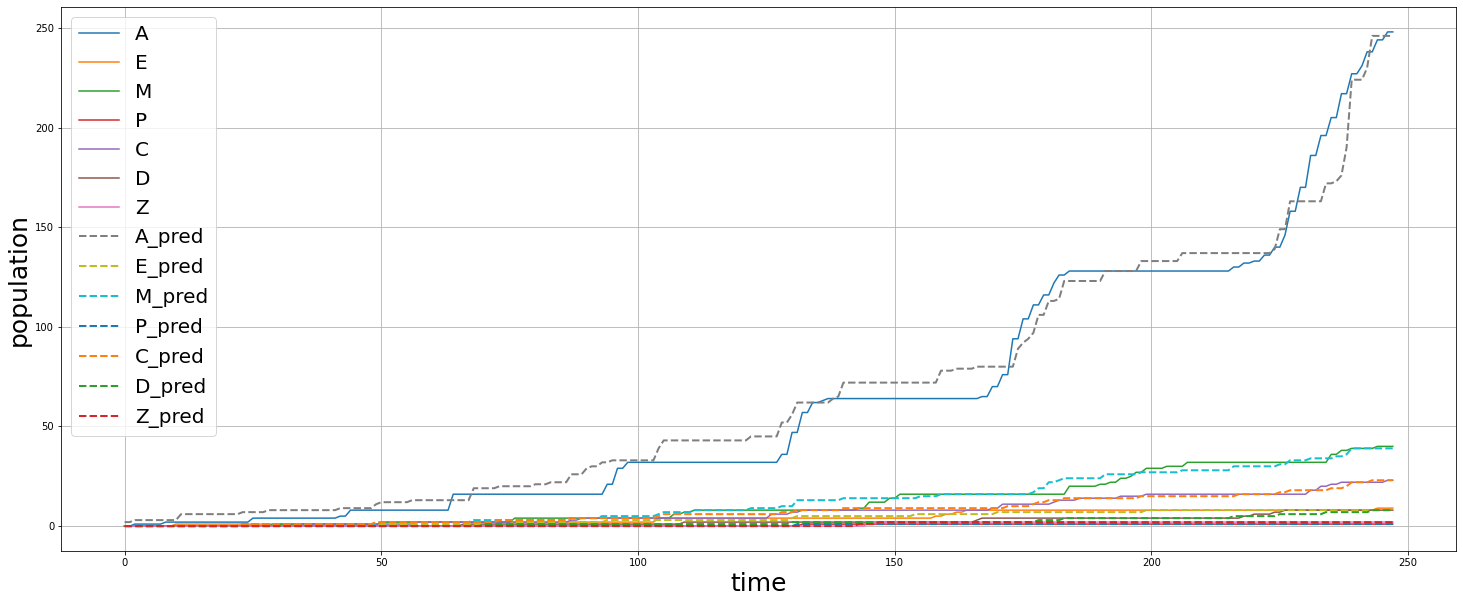

In [57]:
postprocessed_researcher_vs_model(look_for_tag="20080709_ceh-27_1_L1", 
                    model_ = model_1, 
                    scaler_=scaler_1)

## Define `compute_loss()`:
This function runs inference on a single video, using a defined model and its corresponding scaler, and returns the loss. This loss metric basically represents how accurate the predictions are. Less loss is better.

Args:
* look_for_tag = string containing video id.
* model_ = model for running inference.
* scaler_ = contains data scaling attributes for even scaling and unscaling of attributes. 

In [59]:
from sklearn.metrics import mean_squared_error

def compute_loss(look_for_tag, model_, scaler_, postprocess=False):
  df_test = pd.read_csv("scaled_epic_10k.csv")
  df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
  a_pop_upper_limit = 250
  df_test = df_test[df_test["A"] <= a_pop_upper_limit]
  data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
  data_unscaled=df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values
  real_time_plots = []
  
  for i in range(len(df_single_cell.columns[1:])):
      real_time_plots.append(data_unscaled[:,i])

  preds = []
  filenames = df_single_cell.filenames.values

  for i in range (len(filenames)):
      image = cv2.imread(filenames[i])
      tensor = mini_transform(image).unsqueeze(0).to(device)
      pred = model_(tensor).cpu().detach().numpy().flatten()
      preds.append(pred)

  if postprocess:
    preds=postprocess_preds(preds)    
  #preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)
  preds = np.array(preds).astype(np.uint8)
  generated_time_plots = []
  
  for i in range(len(df_single_cell.columns[1:])):
      generated_time_plots.append(preds[:,i])

  loss = mean_squared_error(real_time_plots,generated_time_plots)
  return(loss)

In [61]:
print("\nloss in video id: "+"20080709_ceh-27_1_L1"+" using model_1 (devolearn)=", compute_loss(look_for_tag="20080709_ceh-27_1_L1", 
                                              model_=model_1, 
                                              scaler_=scaler_1))

print("\nloss in video id: "+"20080709_ceh-27_1_L1"+" using model_1 (devolearn)=", compute_loss(look_for_tag="20080709_ceh-27_1_L1", 
                                              model_=model_1, 
                                              scaler_=scaler_1,
                                              postprocess=True))


loss in video id: 20080709_ceh-27_1_L1 using model_1 (devolearn)= 0.0848775532189145

loss in video id: 20080709_ceh-27_1_L1 using model_1 (devolearn)= 0.06356418916361498


## Creating a longer list of video tags for further testing:

In [63]:
df = pd.read_csv("/content/scaled_epic_10k.csv")
df = pd.DataFrame(df.filenames.str.split('/',1).tolist(),
                                 columns = ['dir','filenames'])
df = pd.DataFrame(df.filenames.str.split('/',1).tolist(),
                                 columns = ['vid_id','frame'])
all_tags=list(df.vid_id.unique())

## Compute losses on 36 videos, using 2 different models.

In [64]:
video_losses_1=[]
video_losses_2=[]
for tag in all_tags:
  loss_1=compute_loss(look_for_tag=tag, 
                      model_=model_1, 
                      scaler_=scaler_1,
                      postprocess=False)
  loss_2=compute_loss(look_for_tag=tag, 
                      model_=model_1, 
                      scaler_=scaler_1,
                      postprocess=True)
  video_losses_1.append(loss_1)
  video_losses_2.append(loss_2)

## Plot loss values derived from all 36 videos, for 2 models:
* Red bar(s) = devolearn
* Green bar(s) = upgraded model

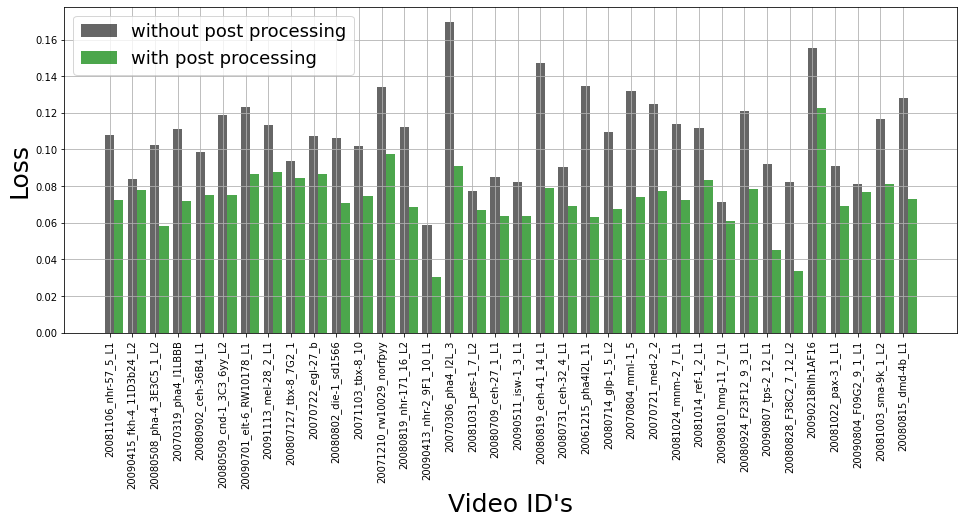

In [74]:
plt.rcParams['figure.figsize'] =16, 6
#plt.rcParams.update(plt.rcParamsDefault)

width = 0.40
labels=all_tags
ind = np.arange(36)
plt.bar(ind, video_losses_1, width, label="without post processing", color='black', alpha=0.6)
plt.bar(ind+width, video_losses_2, width,  label="with post processing", color ='green', alpha=0.7)
plt.xticks(ind, labels, rotation='vertical')
plt.ylabel('Loss', fontsize=25)
plt.xlabel("Video ID's", fontsize=25)
plt.grid()
plt.legend(loc='best', fontsize=18)
plt.show()

## Plot the average loss on all videos, for 2 models:


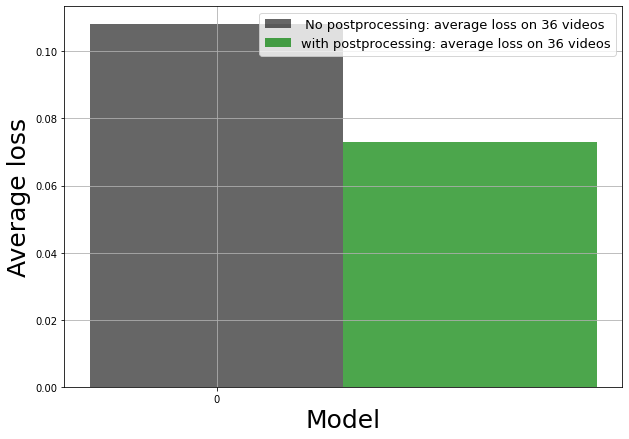

In [75]:
plt.rcParams['figure.figsize'] =10, 7

average_video_losses_1=np.mean(video_losses_1)
average_video_losses_2=np.mean(video_losses_2)
width = 0.10
labels=all_tags
ind = np.arange(1)
plt.bar(ind, average_video_losses_1, width, label=" No postprocessing: average loss on 36 videos", color='black', alpha=0.6)
plt.bar(ind+width, average_video_losses_2, width,  label="with postprocessing: average loss on 36 videos", color='green', alpha=0.7)
plt.xticks(ind)
plt.ylabel('Average loss', fontsize=25)
plt.xlabel("Model", fontsize=25)
plt.grid()
plt.legend(loc='best', fontsize=13)
plt.show()